# Overview

The 2016 US Presidential election is a great opportunity to make some memes.  Lots of people are doing it.  In October of 2016, a meme aggregator called Sizzle shared a subset of their meme data selected for candidate name content.  The data contain over 32,000 memes spanning four networks: Facebook, Instagram, Twitter, and Imgur.  This report first checks the relative quantity of candidate memes across social media platforms.  We then test to see whether memes about Clinton or Trump receive more likes. Finally, we visualize the change in meme liking over time.  Although liking a candidate meme is not equivalent to liking the candidate, it is safe to say that more likes are similar to more attention.  The plot of candidate meme likes over time reveals the monthly competition among US presidential candidates.

# Background

Social Media have played an ever-larger role in US Presidential elections.  During Howard Dean's 2004 election bid, campaign manager Joe Trippi leveraged online services, including blogs, to organize a "grassroots" fundraising movement that was surprisingly successful.  Barack Obama's 2008 and 2012 campaigns made extensive use of existing social media platforms - including Facebook - but also developed their own platforms for specific operations like the Dean campaign had.  In the lead-up to the 2016 campaign, Eric Schmidt guided the formation of The Groundwork, a team of web specialists who would develop specific expertise for consulting with political campaigns.  The 2016 Clinton campaign has, in all likelihood, inherited much of this IT expertise.  Less is understood about the 2016 Trump campaign, but it is already clear that Social Media are central to the campaign's strategy.



## Political Advertising, Geography, and Hashtags

The traditional model of political advertising has derived from social persuasion.  The "mere exposure" effect, in which the simple act of seeing a name repeatedly leads to greater liking for that name, accounts for the success of simple poster-style political messaging like lawn signs.  However, what was effective several decades ago is now much less effective due to the pervasiveness of media, and in particular, social media.

Voter segmentation is the natural evolution of advertising-oriented political campaigning.  Good data and statistical analysis are required for voter segmentation to be effective. Segmentation seems to naturally map onto geographically partitioned federal and state districts, so at first glance, the technique appears to offer great value.  What began in the 1970s with nationwide telephone polling has now been perfected by statisticians like Nate Silver to the extent that virtually every district-by-district scenario can be tested for its electoral consequences.

As information technology has overcome geographical distances, geographical segmentation may no longer be the best predictor of political outcomes.  The "long tail" dynamics of niche economies are only possible when individuals are aggregated across geographies, not bounded within.  A more accurate metaphor for our political reality in 2016 is the chatroom or hashtag, in which people dynamically self-aggregate based solely upon belief.  This underlying principle of shared belief signifies the changing political paradigm; advertising becomes psychology.

Social media is an attractive platform for political campaigning.  With relatively little expense, it is possible to reach vast online audiences through viral mechanisms of propagation.  Viral propagation is itself influenced by the beliefs of the individuals who participate in social media sharing.  In this manner, hashtags - not geographical segments - should more closely track to the true beliefs of potential voters. The unit of political analysis shifts from geographical regions to individual online personae.



## Rational Social Media Agents

One model of social media sharing suitable for individual-level analysis assumes that a rational human controls the social media experience.  Imagine you are using social media and you are deciding whether to "like" a political meme.  Now imagine this is an economic process, and consider the risks and benefits of "liking" that media.  Does your act of liking it reveal your private political beliefs? And so on.  Let us refer to this as the Rational Agent model of Social Media, and throughout these analyses we will consider that each "like" appearing in the data was created by Rational Agent.

However, we know the Rational Agent model is simplistic; it was challenged during the 2016 election season when questions were raised about Facebook news curation, Reddit moderation, and Twitter censorship, Google's ranking algorithm, and so on.  While it has long been a trope that "mainstream media" are biased, presumably due to the centralization of publishing power, now the same accusations are being levied at social media platforms.  Therefore, certain external forces may influence the very experiences a Rational Agent may encounter, which will influence meme creation and liking rates.

## Bots

Even as social media platforms consolidate power, those platforms have been leveraged by bot networks to increase the quantity of certain messages, alter the visibility of messages, spam comment threads, and vote to influence discussions.  Bot networks, just like media platforms, represent the consolidation of control over network messaging.  Therefore, our Agent model must allow for malicious actors who generate fake behaviours that are mixed with real behaviours in a way that we cannot distinguish.

The social media landscape is complex and the political battle currently being waged through these media is very messy, resulting in lots of noise in our social media data.  Vast quantities of social media "likes" are attributable to non-human agents.  With this caveat in mind, the current report looks at data aggregated by Sizzle, an online meme aggregator.

# Methods

Data are from Sizzle, an online meme aggregator. Sizzle have coded the meme caption content and exported certain memes that matched candidate names.  Each meme has the following data properties: 

- platform: facebook, instagram, twitter, imgur
- url: the URL for the meme
- likes: how many likes the meme received
- caption: the text of the caption

The general approach for this study is to import all the available CSV data, categorize it by candidate, and standardize the likes between social media platforms. This report is built with the R Language version 3.3.1.  The report is currently available as a Jupyter-style notebook via Kaggle.

In [1]:
# This report uses several R libraries and settings, which are specified here.
options(warn=-1)
library(ggplot2)
library(readr)
library(lubridate)
options(warn=0)
set.seed(1620)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



## Data Aggregation

The Sizzle data are separated by keyword, with a separate keyword corresponding to a separate CSV file.  Because some candidates have results that are split across multiple files, we must aggregate across files.  The data don't load perfectly, so we also need to convert a few columns and parse timestamps.

In [2]:
mapping = list(
    c("sanders", "../input/Bern.csv"),
    c("sanders", "../input/Bernie.csv"),
    c("clinton", "../input/Clinton.csv"),
    c("trump", "../input/Donald.csv"),
    c("johnson", "../input/Gary_Johnson.csv"),
    c("clinton", "../input/Hillary.csv"),
    c("stein", "../input/Jill_Stein.csv"),
    c("trump", "../input/Trump.csv")
)

df = data.frame()

for (tuple in mapping) {
    tmp = read.csv(tuple[2])
    tmp[["candidate"]] = tuple[1]
    df = rbind(df, tmp)
}

df[["candidate"]] = as.factor(df[["candidate"]])
df[["caption"]] = as.character(df[["caption"]])

# parse time and create month time periods
df[["timestamp"]] = as.POSIXct(strptime(df[["timestamp"]], format = "%m/%d/%y %H:%M"))
df[["period"]] = paste(year(df[["timestamp"]]), month(df[["timestamp"]]), "1", sep="-")
df[["period"]] = as.POSIXct(strptime(df[["period"]], format="%Y-%m-%d"))

## Scoring

Because social media platforms vary in their users and capabilities, liking dynamics are not the same across networks.  As a result, we must standardize likes within networks so that we can make comparisons  with all the available data.

In [3]:
for (network in c('facebook', 'instagram', 'twitter')) {
    cdf = ecdf(df[which(df[["network"]]==network),'likes'])
    df[which(df[["network"]]==network),'percentile'] = cdf(df[which(df[["network"]]==network),'likes'])
    df[which(df[["network"]]==network),'z_score'] = scale(df[which(df[["network"]]==network),'likes'], center = TRUE, scale = TRUE)
}

# no scores for imgur, so set it all to 0
df[which(df[["network"]]=='imgur'),'percentile'] = 0
df[which(df[["network"]]=='imgur'),'z_score'] = 0

During development, it is useful to double-check the data.  This report is typically rendered with the following setting as FALSE, which skips the debugging step.

In [4]:
# Preview the raw data to ensure everything was loaded properly.
if (FALSE) {
    dim(df)
    head(df, 1)
    str(df)    
}

# Results

First, we will briefly describe the distribution of memes.  Next, we'll look for differences between the two main candidates.  Finally, we'll observe the candidate memes over time.

## How many memes were created for each candidate?

A simple visualization displays the total quantity of memes made about the candidates, as well as the platform where those memes were shared.

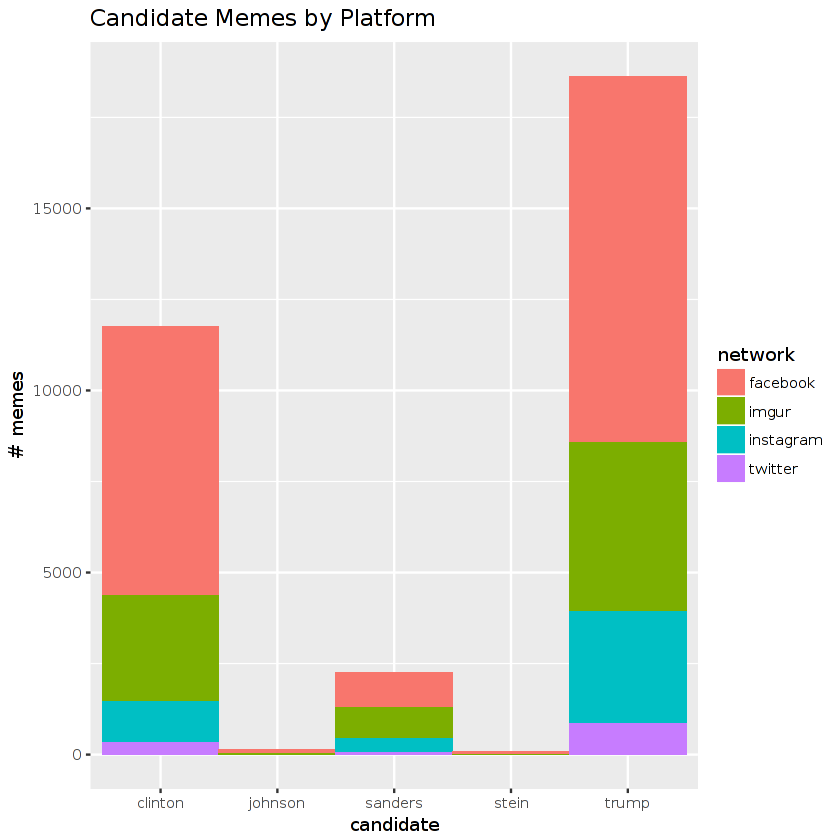

In [5]:
ggplot(data=df, aes(x=candidate, fill=network)) +
    stat_count(width = 1) + 
    ggtitle("Candidate Memes by Platform") +
    ylab("# memes") +
    xlab("candidate")

If anything, there may be a surprising number of Trump memes shared on Instagram, but otherwise the candidates appear to be proportionally distributed across platforms.

## Test for differences between candidates in terms of likes

We will compare the standardized, centred scores between the two main candidates: Clinton and Trump.

In [6]:
percentiles = df[which(df[["percentile"]] > 0),]
z_scores = df[which(df[["z_score"]] > 0),]
t.test(x = df[which(df[["candidate"]]=='clinton'),'z_score'],
       y = df[which(df$candidate=='trump'),'z_score'])


	Welch Two Sample t-test

data:  df[which(df[["candidate"]] == "clinton"), "z_score"] and df[which(df$candidate == "trump"), "z_score"]
t = -5.3114, df = 30228, p-value = 1.095e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.06765807 -0.03118327
sample estimates:
  mean of x   mean of y 
-0.02661696  0.02280371 


From these data, it appears Clinton memes are liked a little bit less than average, whereas Trump memes are liked a little bit more.  There is a small but statistically significant difference between mean likes among these candidates.

# Change in like scores over time

Campaigns unfold over time and over the course of many media events. Candidates alternately have their moments of media spotlight on the basis of the attention they can attract. This attention may manifest as memes, which in turn create opportunities for likes. Since attention and likes will vary over time, we broke down meme scores by month to investigate time effects.

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

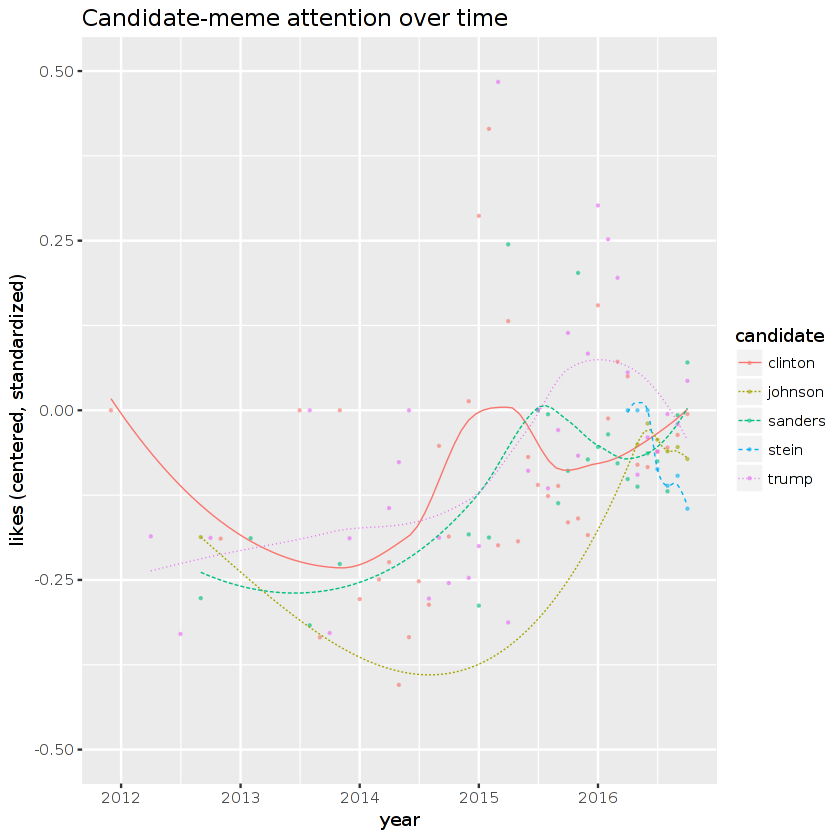

In [7]:
averages = aggregate( z_score ~ period * candidate, df, mean )
averages[["z_score"]] = averages[["V1"]]

ggplot(data=averages, 
       aes(x=period, y=z_score, color=candidate)) +
    geom_point(aes(color=candidate), size=0.2, alpha=0.5) + 
    geom_smooth(
        aes(color=candidate, linetype=candidate),
        se=FALSE,
        method='loess',
        size=0.3,
        alpha=0.5) + 
    ggtitle("Candidate-meme attention over time") +
    ylab("likes (centered, standardized)") +
    xlab("year") +
    ylim(c(-0.5, 0.5))

The plot depicts monthly average *like* scores for each candidate, and a moving-average regression line (LOESS) has been fit to the data.  The ups and downs of candidates over time, despite being called likes, should probably be interpreted as *attention* over time.  Trump memes are seen to achieve a huge amount of attention during the early part of 2016.  It is only in the most recent months that Clinton memes begin to gain relatively-more likes (and therefore, attention).

The story of the Trump campaign's success with social media is clearly spelled out in this plot.  The huge surge in likes from mid-2015 through mid-2016 corresponded to a huge amount of attention for Trump.  It is not clear whether the memes are pro-Trump or anti-Trump, but we can safely infer that either way, Trump memes were probably reaching more viewers.

# Conclusion

Do the people like Trump or Clinton?  We can't say from these data, at least not directly.  Even if we were to employ sentiment tagging (e.g. with LIWC or another tool) it would not be possible to say with certainty whether the act of liking a meme translates to liking a candidate.

However, we can qualitatively digest the meme attention plot and conclude that it sounds about right.  It sortof looks like an opinion poll, although we can be certain it does not reflect popular opinion.  It sortof looks like a popularity plot for trending tags or terms, but again, it's not quite that either.  Quite simply, the meme attention plot depicts how much general attention was given to memes about candidates over the course of months, and that's interesting on its own.

Does the last-minute uptick in Clinton memes mean something important?  Again, it is not possible to determine whether these memes are pro- or anti-candidate, so all we can say is that Clinton is receiving more likes and attention.  Perhaps this is a good thing, as with "mere exposure" advertising.  On the other hand, perhaps these last-minute Clinton memes are all critical, suggesting a turn in the tide.  Only time will tell.

Be sure to vote by November 8, 2016.